# Metric learning for image similarity search

Metric learning aims to train models that can embed inputs into a high-dimensional space such that "similar" inputs, as defined by the training scheme, are located close to each other. These models once trained can produce embeddings for downstream systems where such similarity is useful; examples include as a ranking signal for search or as a form of pretrained embedding model for another supervised problem.

For a more detailed overview of metric learning see:

* [What is metric learning?](http://contrib.scikit-learn.org/metric-learn/introduction.html)
* [Using crossentropy for metric learning tutorial](https://www.youtube.com/watch?v=Jb4Ewl5RzkI)

In [1]:
!sudo pip install --quiet objax

In [2]:
import numpy as np
import jax.numpy as jnp
import objax

# Dataset

For this example we will be working with the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset.

First we read the entire dataset into `X=(N, 32, 32, 3)` and `y=(N,)` tensors for the training and test splits.

In [3]:
import tensorflow_datasets as tfds
import tensorflow as tf

def read_and_convert(tfds_dataset, split):
    # Load TF dataset and collect all examples in arrays.
    dataset = tfds.load('cifar10', split=split)
    x, y = [], []  
    for example in dataset.prefetch(tf.data.experimental.AUTOTUNE):
      x.append(example['image'])
      y.append(example['label'])

    # Stack x and y into (N, 32, 32, 3) and (N,) tensors.
    x = jnp.array(np.stack(x))
    y = jnp.array(np.stack(y))

    # Do dtype conversion of image from uint8 (0, 255) to float (0.0, 1.0).
    x = x.astype(jnp.float32) / 255

    # Objax conv2d defaults to CHW so transpose HWC -> CHW now.
    x = jnp.transpose(x, (0, 3, 1, 2))

    # Return as Jax arrays.
    return x, y

x_train, y_train = read_and_convert('cifar10', 'train')
x_test, y_test = read_and_convert('cifar10', 'test')

print("train shapes", x_train.shape, y_train.shape)
print("test shapes", x_test.shape, y_test.shape)

train shapes (50000, 3, 32, 32) (50000,)
test shapes (10000, 3, 32, 32) (10000,)


To get a sense of the dataset we can visualise a grid of 25 random examples.

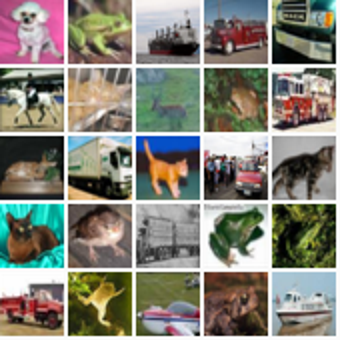

In [4]:
from PIL import Image

height_width = 32

def show_collage(examples):
    # Transpose N, M images back to HWC for PIL.
    examples = examples.transpose((0, 1, 3, 4, 2))    
    box_size = height_width + 2
    num_rows, num_cols = examples.shape[:2]
    collage = Image.new(
        mode="RGB",
        size=(num_cols * box_size, num_rows * box_size),
        color=(250, 250, 250),
    )
    for row_idx in range(num_rows):
        for col_idx in range(num_cols):
            array = (np.array(examples[row_idx, col_idx]) * 255).astype(np.uint8)
            collage.paste(
                Image.fromarray(array), (col_idx * box_size, row_idx * box_size)
            )
    # Double size for visualisation.
    collage = collage.resize((2 * num_cols * box_size, 2 * num_rows * box_size))
    return collage

# Show a collage of 5x5 random images.
sample_idxs = np.random.randint(0, 50000, size=(5, 5))
examples = x_train[sample_idxs]
show_collage(examples)

Metric learning provides training data not as explicit `(X, y)` pairs but instead uses multiple instances that are related in the way we want to express similarity. 

In our example we will use instances of the same class to represent similarity; a single training instance will not be one image, but a pair of images of the same class. When referring to the images in this pair we'll use the common metric learning names of the `anchor` (a randomly chosen image) and the `positive` (another randomly chosen image of the same class).

To facilitate this we need to build a form of lookup that maps from classes to the instances of that class. When generating data for training we will sample from this lookup. ( Recall that CIFAR-10 includes 10 classes. )

In [5]:
from collections import defaultdict

num_classes = 10

class_idx_to_train_idxs = defaultdict(list)
for y_train_idx, y in enumerate(y_train):
    class_idx_to_train_idxs[y].append(y_train_idx)

class_idx_to_test_idxs = defaultdict(list)
for y_test_idx, y in enumerate(y_test):
    class_idx_to_test_idxs[y].append(y_test_idx)

For this example we will use the [N-pair](https://papers.nips.cc/paper/6200-improved-deep-metric-learning-with-multi-class-n-pair-loss-objective) approach to sampling; a batch will consist of (anchor, positive) pairs spread across the classes. The goal of learning will be to move the anchor and positive pairs closer together and further away from other instances in the batch. In this case the batch size will be dictated by the number of classes; for CIFAR-10 this is 10.

In [6]:
import random

def sample_training_batch():  
    # Sample a training batch of (2, N) images.
    # The first axis denotes anchor or positive.
    # The second axis denotes the N classes.
    idxs = np.empty((2, num_classes), dtype=np.int)
    for class_idx in range(num_classes):
        examples_for_class = class_idx_to_train_idxs[class_idx]
        anchor_idx = random.choice(examples_for_class)
        positive_idx = random.choice(examples_for_class)
        while positive_idx == anchor_idx:
            positive_idx = random.choice(examples_for_class)
        idxs[0, class_idx] = anchor_idx
        idxs[1, class_idx] = positive_idx
    return x_train[idxs]

We can review a random training batch of data. Here the rows correspond to the anchors and positives. Each column corresponds to one of the ten classes from CIFAR-10; Airplane, Automobile, Bird, Cat, Deer, Dog, Frog, Horse, Ship & Truck.

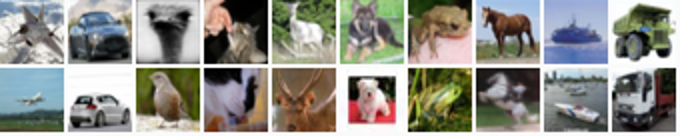

In [7]:
show_collage(sample_training_batch())

# Embedding model

Next we define a embedding network with a simple architecure consisting of 

* a stack of convolutional layers
* global pooling and
* an embedding layer

As is common in metric learning we normalise the embeddings so that we can use simple dot products to measure similarity. For simplicity this model is intentionally small.

In [8]:
class EmbeddingNet(objax.Module):

    def __init__(self, embedding_dim=8):
        self.convs = objax.nn.Sequential([objax.nn.Conv2D(nin=3, nout=32, k=3, strides=2),
                                          objax.functional.relu,
                                          objax.nn.Conv2D(nin=32, nout=64, k=3, strides=2),
                                          objax.functional.relu,
                                          objax.nn.Conv2D(nin=64, nout=128, k=3, strides=2),
                                          objax.functional.relu])
        self.embeddings = objax.nn.Linear(nin=128, nout=embedding_dim)

    def __call__(self, x, training):    
        # Apply convolutional stack.
        x = self.convs(x)
        # Apply spatial global pooling.
        x = jnp.mean(x, axis=(2, 3))
        # Calculate embeddings, and normalise them to unit length.
        embeddings = self.embeddings(x)    
        embeddings /= jnp.linalg.norm(embeddings, axis=-1, keepdims=True)
        return embeddings    


embedding_model = EmbeddingNet()

As a loss function we use the general metric learning approach of embedding both anchors and positives and then using their pairwise dot products as logits for a softmax. See the [Using crossentropy for metric learning tutorial](https://www.youtube.com/watch?v=Jb4Ewl5RzkI) for a deeper walkthrough of this idea.

In [9]:
from objax.functional.loss import cross_entropy_logits_sparse

def loss(batch):
    # Run both anchors and positives through model.
    anchor_embeddings = embedding_model(batch[0], training=True)
    positive_embeddings = embedding_model(batch[1], training=True)

    # Calculate cosine similarity between anchors and positives. As they have
    # been normalised this is just the pair wise dot products.
    similarities = jnp.einsum("ae,pe->ap", 
                              anchor_embeddings, positive_embeddings)
    
    # Since we intend to use these as logits we scale them by a temperature.
    # This value would normally be chosen as a hyper parameter.
    temperature = 0.2
    similarities /= temperature    
    
    # We use these similarities as logits for a softmax. The labels for
    # this call are just the sequence [0, 1, 2, ..., num_classes] since we
    # want the main diagonal values, which correspond to the anchor/positive
    # pairs, to be high. This loss will move embeddings for the
    # anchor/positive pairs together and move all other pairs apart.
    sparse_labels = jnp.arange(num_classes)
    return jnp.mean(cross_entropy_logits_sparse(logits=similarities,
                                                labels=sparse_labels))

# Training

We use Adam as an optimiser and Objax's helpers to create a training op.

In [10]:
optimiser = objax.optimizer.Adam(embedding_model.vars())
grad_values = objax.GradValues(loss, embedding_model.vars())

learning_rate = 1e-3
def train_op(batch):
    gradients, _loss_value = grad_values(batch)
    optimiser(learning_rate, gradients)    

train_op = objax.Jit(train_op, optimiser.vars() + grad_values.vars())

Finally we run this training op for a simple fixed number of steps, reporting a sample batch loss value at the end of each "epoch".

In [11]:
for epoch in range(10):
    for step in range(1000):
        train_op(sample_training_batch())
    print("epoch", epoch, "sample loss", loss(sample_training_batch()))

epoch 0 sample loss 1.9787697
epoch 1 sample loss 2.0620773
epoch 2 sample loss 1.697345
epoch 3 sample loss 2.015735
epoch 4 sample loss 1.8019339
epoch 5 sample loss 1.6297076
epoch 6 sample loss 1.8829625
epoch 7 sample loss 1.7909096
epoch 8 sample loss 2.0740013
epoch 9 sample loss 1.3543228


# Testing

We can review the quality of this model by applying it to the test set and considering nearest neighbours in the embedding space.

First we embed the entire test set and calculate all nearest neighbours. Recall that since the embeddings are unit length we can calculate cosine similarity via dot products.

In [12]:
nearest_neighbours_per_example = 10
embeddings = embedding_model(x_test, training=False)
gram_matrix = jnp.einsum("ae,be->ab", embeddings, embeddings)
nearest_neighbours = np.argsort(gram_matrix.T)[:, -(nearest_neighbours_per_example + 1) :]

/usr/local/lib/python3.6/dist-packages/jax/numpy/lax_numpy.py:3285: UserWarning: 'kind' argument to argsort is ignored.
  warnings.warn("'kind' argument to argsort is ignored.")


As a visual check of these embeddings we can build a collage of the nearest neighbours for 5 random examples. The first column of the image below is a randomly selected image, the following 10 columns show the nearest neighbours in order of similarity.

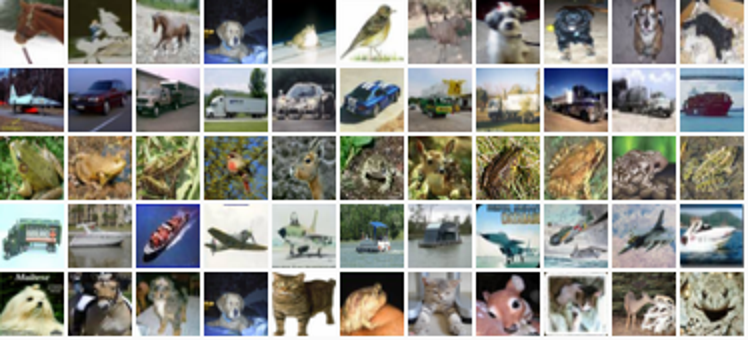

In [13]:
num_collage_examples = 5

examples = np.empty((num_collage_examples,
                     nearest_neighbours_per_example + 1,
                     3, height_width, height_width), dtype=np.float32)
for row_idx in range(num_collage_examples):
    examples[row_idx, 0] = x_test[row_idx]
    anchor_nearest_neighbours = reversed(nearest_neighbours[row_idx][:-1])
    for col_idx, nn_idx in enumerate(anchor_nearest_neighbours):
        examples[row_idx, col_idx + 1] = x_test[nn_idx]

show_collage(examples)

We can also get a quantified view of the performance by considering the correctness of nearest neighbours in terms of a confusion matrix.

Let us sample 10 examples from each of the 10 classes and consider their nearest neighbours as a form of prediction; that is, does the example and its nearest neighbours share the same class?

We observe that each animal class does generally well, and is confused the most with the other animal classes. The vehicle classes follow the same pattern; e.g. Automobile is often a nearest neighbour for Truck.

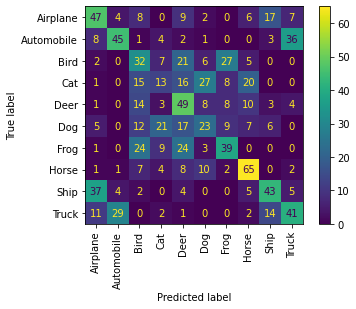

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

confusion_matrix = np.zeros((num_classes, num_classes))

# For each class.
for class_idx in range(num_classes):
    # Consider 10 examples.
    example_idxs = class_idx_to_test_idxs[class_idx][:10]
    for y_test_idx in example_idxs:
        # And count the classes of its nearest neighbours.
        for nn_idx in nearest_neighbours[y_test_idx][:-1]:
            nn_class_idx = y_test[nn_idx]
            confusion_matrix[class_idx, nn_class_idx] += 1

# Display a confusion matrix.
labels = ["Airplane", "Automobile", "Bird", "Cat", "Deer", "Dog", "Frog", 
          "Horse", "Ship", "Truck"]
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=labels)
disp.plot(include_values=True, cmap="viridis", ax=None, xticks_rotation="vertical")
plt.show()